# TP1 - Grupo 4 - Pasajeros

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
import scipy.stats
import pylab
import statsmodels.tsa.stattools as tsa
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

##########################################################################################
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import ADFTest
##########################################################################################

from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie: Pasajeros')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie: Pasajeros diferenciado')
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

# Pasajeros 

Pasajeros por línea a partir del 30 de septiembre del 2021

In [4]:
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Pasajeros_TP.csv'
pasajeros_d = pd.read_csv(url)
pasajeros_d.rename({'FechaRecaudacion': 'fecha', 'Cantidad_Pasajeros': 'pas'}, axis=1, inplace=True)
pasajeros_d = pasajeros_d[(pasajeros_d['fecha'] >= '2021-10-01') & (pasajeros_d['fecha'] <= '2023-10-30')]


In [5]:
# Para la fecha jueves 13 de octubre del 2022, se observa el valor de 1 y para corregir este dato se optó por sacar el promedio de los dos dias posteriores y el valor del día anterior.
# Además se agregan las observaciones que corresponden a los días 2022-05-17, 2022-10-12, 2023-06-13 y 2023-06-22 con el valor de 1, posteriormente se reemplaza este valor por el promedio de los dos dias posteriores y el valor del día anterior.
# Agregar fechas faltantes
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'pas': 1},
                                     {'fecha': '2022-10-12', 'pas': 1},
                                     {'fecha': '2023-06-13', 'pas': 1},
                                     {'fecha': '2023-06-22', 'pas': 1}])
pasajeros_d = pd.concat([pasajeros_d, nuevas_observaciones], ignore_index=True)

In [7]:
# Ordenar el DataFrame por la columna de fechas
pasajeros_d = pasajeros_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
pasajeros_d = pasajeros_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'], dayfirst=True, format="%Y-%m-%d")

In [8]:
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_17 = round(average_value_17, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_17

In [9]:
# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_12 = round(average_value_12, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_12

In [10]:
# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_13 = round(average_value_13, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_13

In [11]:
# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_6 = round(average_value_6, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_6

In [12]:
# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_22 = round(average_value_22, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_22

In [13]:
# Formato diario
pasajeros_d.set_index('fecha', inplace=True)

pasajeros_d.head()

,pas
fecha,
2021-10-01,163933
2021-10-02,71862
2021-10-03,41802
2021-10-04,159940
2021-10-05,170473


In [14]:
pasajeros_d = pasajeros_d.asfreq('d')
pasajeros_d

,pas
fecha,
2021-10-01,163933
2021-10-02,71862
2021-10-03,41802
2021-10-04,159940
2021-10-05,170473
...,...
2023-10-26,299281
2023-10-27,285229
2023-10-28,148798


In [15]:
pasajeros_d = pasajeros_d['pas']
pasajeros_d.describe()

count       760.000000
mean     175952.678947
std       82497.043937
min        5582.000000
25%      106144.500000
50%      178343.000000
75%      249701.000000
max      319953.000000
Name: pas, dtype: float64

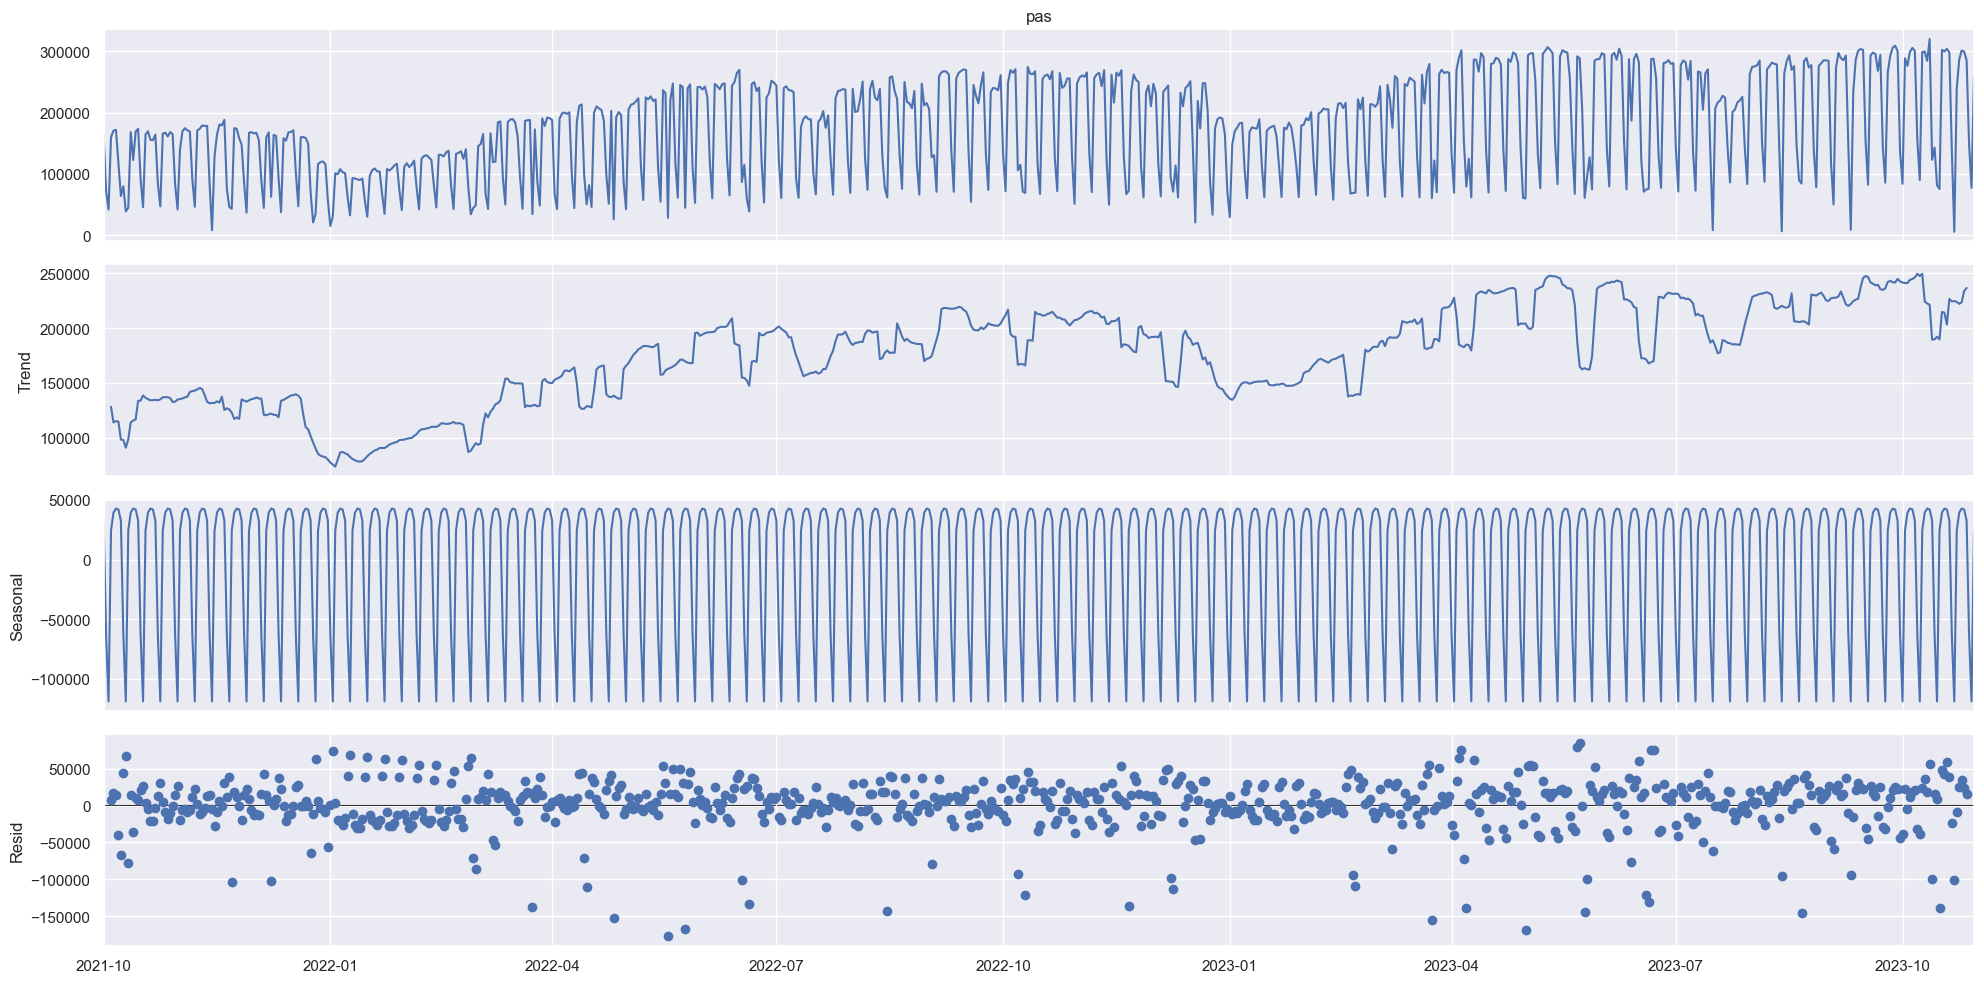

In [16]:
# Descomposición aditiva de la serie diferenciada
from statsmodels.tsa.seasonal import seasonal_decompose

s_dec_additive = seasonal_decompose(pasajeros_d, model = "adittive")
s_dec_additive.plot()
plt.show()

# Pregunta 2

Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.

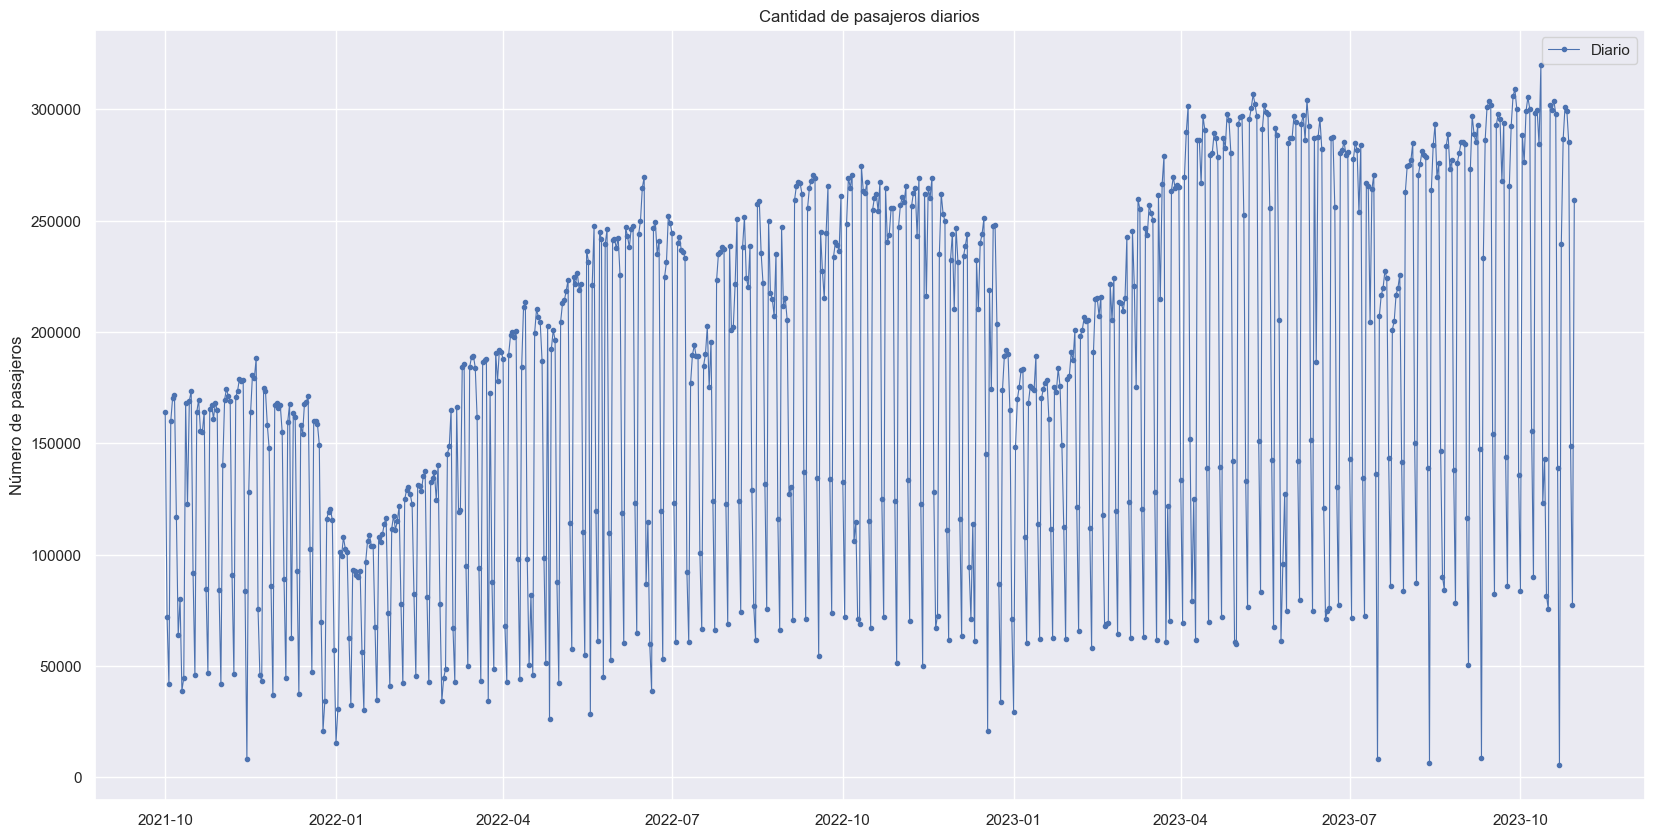

In [17]:
#Visualización serie original

plt.plot(pasajeros_d.loc['2021-09':,], marker='.', linestyle='-', linewidth=0.8, label='Diario')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.title('Cantidad de pasajeros diarios')
plt.show()

In [34]:
# Pasajeros
#pasajeros_d.pas.plot(figsize=(35,8), title = 'Serie original');

La serie diaria de pasajeros muestra una baja en los meses de verano y un incremento luego del inicio de clases. Además se puede ver que del 2022 al 2023 hubo una mayor cantidad de pasajeros si se trata de comparar con el día del año anterior.

Por lo tanto se opta por diferenciar esta serie para que sea estacionaria, ya que de forma visual hay una clara tendencia creciente y una estacionalidad marcada.

Para determinar el número de diferenciaciones necesarias para que una serie temporal sea estacionaria utilizamos pm.arima.ndiffs:

In [16]:
print(pm.arima.ndiffs(pasajeros_d))

1


In [17]:
# Diferenciar la serie
pas_diff=pasajeros_d.copy()
pas_diff=pas_diff.diff(periods = 1)
pas_diff = pas_diff.dropna()

In [18]:
# Funcion para graficar

def graficar(serie, titulo="", xlabel="Mes", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

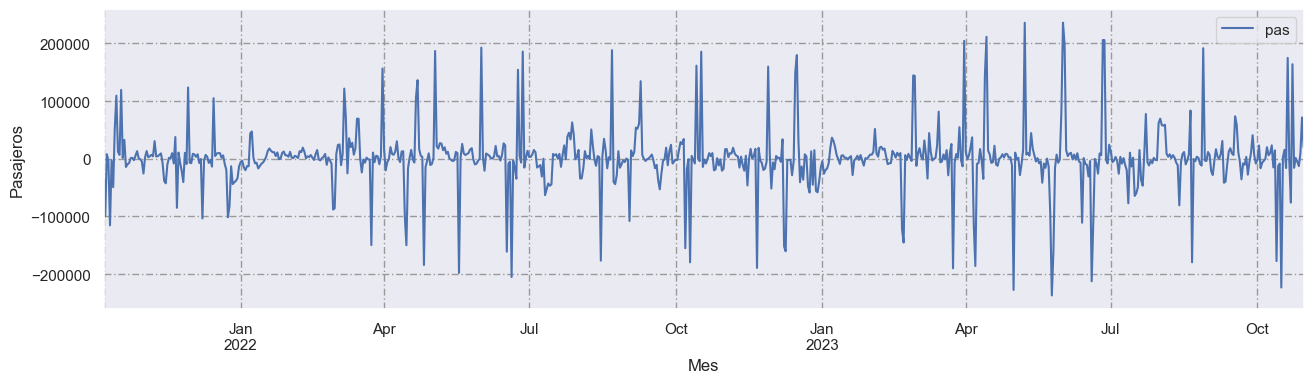

In [19]:
# Para remover la estacionalidad semanal,
# Hacemos una diferencia semanal y en el grafico ya no observamos un patron repetitivo

# Diferenciar la serie
pas_diff_7=pasajeros_d.copy()
pas_diff_7=pas_diff_7.diff(periods = 7)
pas_diff_7 = pas_diff_7.dropna()
graficar(pas_diff_7)

# Pregunta 3

Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría

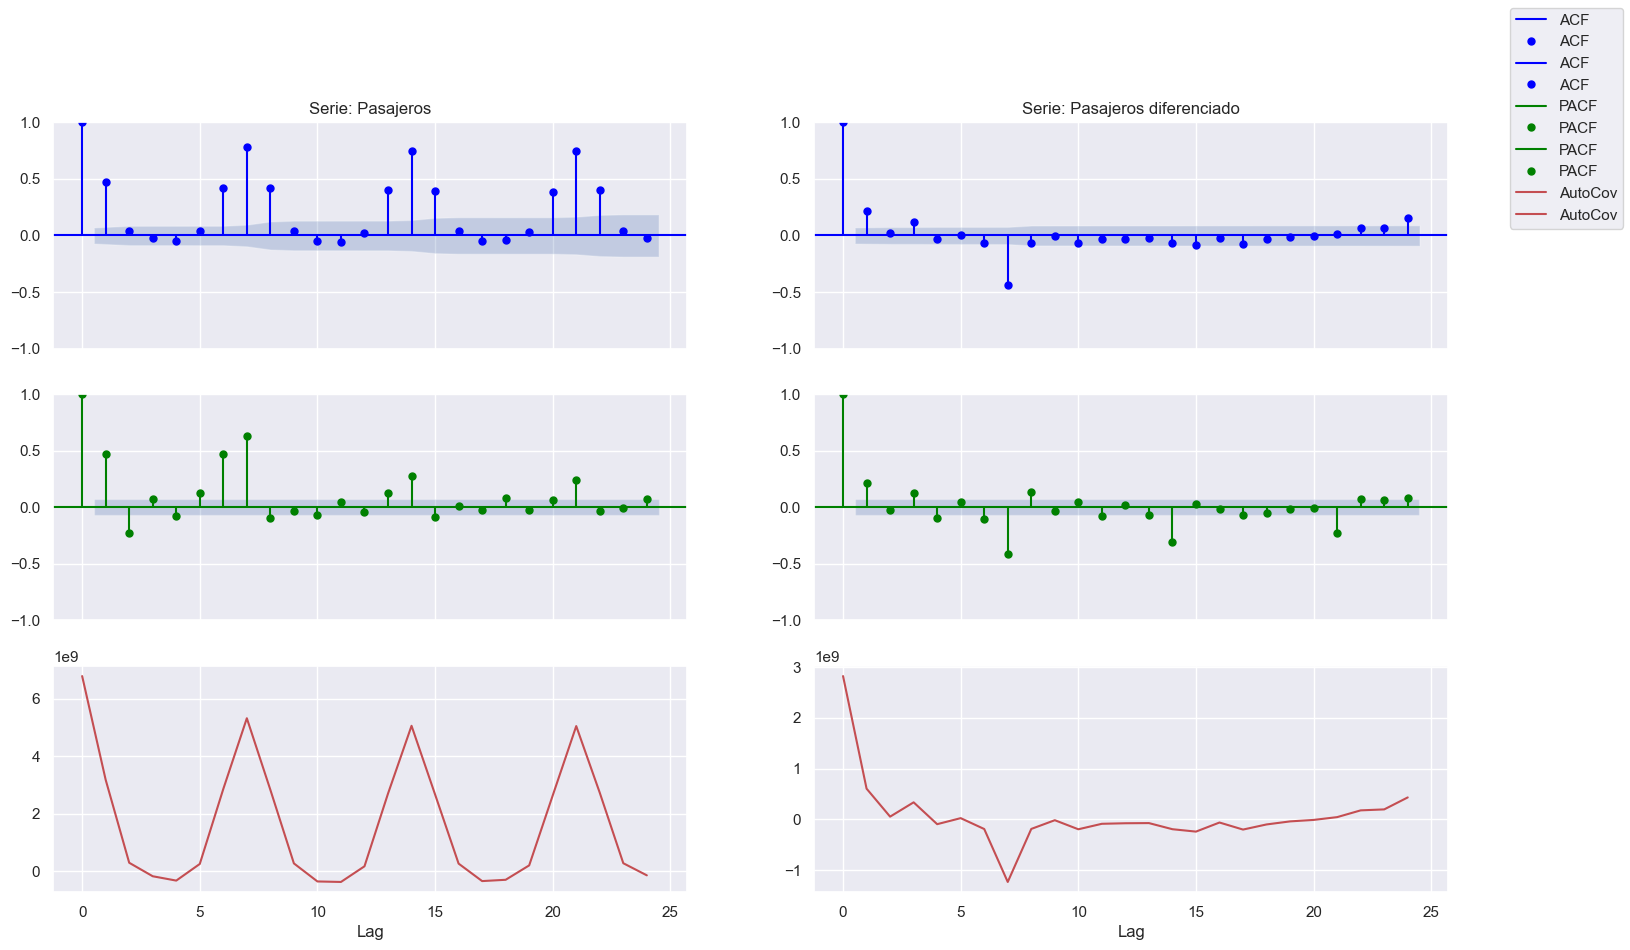

In [20]:
# Grafica diferentes funciones de la serie Pasajeros
autocov_autocorr(pasajeros_d, pas_diff_7, 24)

# Pregunta 4

Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

In [21]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Results of Dickey-Fuller Test for column: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Reject the null hypothesis")
    print("Data is stationary")
  else:
    print("Conclusion:====>")
    print("Fail to reject the null hypothesis")
    print("Data is non-stationary")

In [22]:
# Dicky Fuller Serie original
Augmented_Dickey_Fuller_Test_func(pasajeros_d,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                  -1.459919
p-value                          0.553238
No Lags Used                    20.000000
Number of Observations Used    740.000000
Critical Value (1%)             -3.439218
Critical Value (5%)             -2.865454
Critical Value (10%)            -2.568854
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [23]:
# Dicky Fuller Serie pas_diff
Augmented_Dickey_Fuller_Test_func(pas_diff,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                -1.183676e+01
p-value                        7.757945e-22
No Lags Used                   1.900000e+01
Number of Observations Used    7.400000e+02
Critical Value (1%)           -3.439218e+00
Critical Value (5%)           -2.865454e+00
Critical Value (10%)          -2.568854e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [24]:
# Dicky Fuller Serie pas_diff_7
Augmented_Dickey_Fuller_Test_func(pas_diff_7,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                -1.074252e+01
p-value                        2.794540e-19
No Lags Used                   2.000000e+01
Number of Observations Used    7.330000e+02
Critical Value (1%)           -3.439303e+00
Critical Value (5%)           -2.865491e+00
Critical Value (10%)          -2.568874e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


# Pregunta 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual global de los parámetros del modelo).

In [25]:
# Separacion Train/Test
# Seleccionamos el primer 80% para train
train = pasajeros_d.iloc[:round(len(pasajeros_d)*.80)]

# Seleccionamos el 20% restante para test
test = pasajeros_d.iloc[round(len(pasajeros_d)*.80):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

fecha
2021-09-30    153297
2021-10-01    163933
2021-10-02     71862
2021-10-03     41802
2021-10-04    159940
               ...  
2023-05-27    127164
2023-05-28     74737
2023-05-29    284632
2023-05-30    287074
2023-05-31    287148
Freq: D, Name: pas, Length: 609, dtype: int64 fecha
2023-06-01    296967
2023-06-02    294234
2023-06-03    141936
2023-06-04     79393
2023-06-05    293552
               ...  
2023-10-26    299281
2023-10-27    285229
2023-10-28    148798
2023-10-29     77246
2023-10-30    259062
Freq: D, Name: pas, Length: 152, dtype: int64


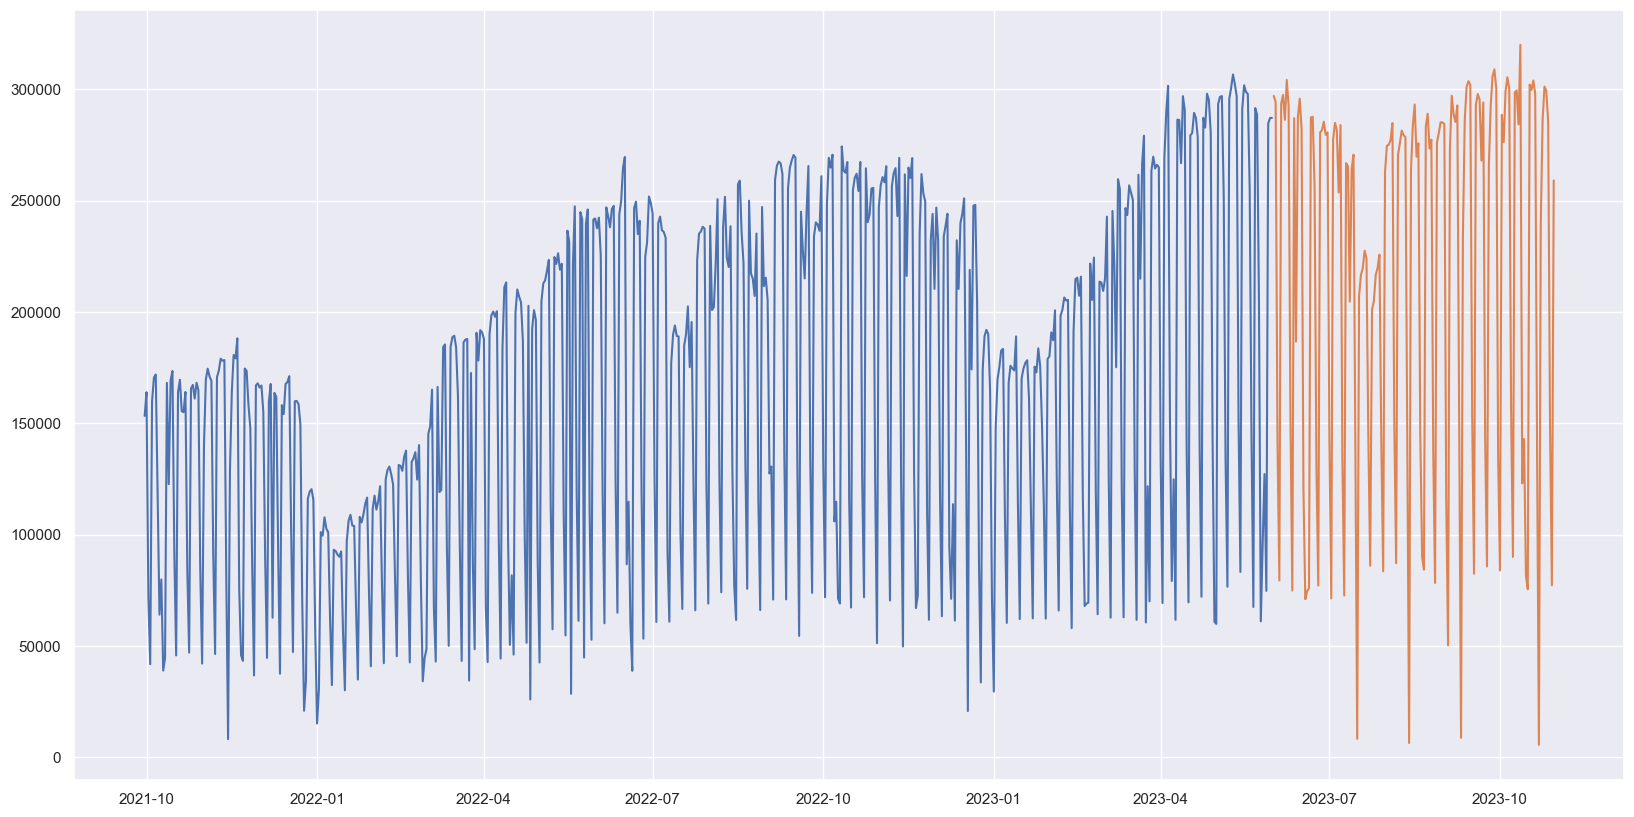

In [26]:
# Visualización Train - Test

plt.plot(train)
plt.plot(test)

In [27]:
# Usamos la funcion auto_arima del paquete pmdarima para optimizar la combinacion de hiperparametros para el modelo SARIMA

auto_arima(train, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
                            start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
                            seasonal=True, m=7, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15461.980, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=15156.872, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=15166.221, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=15459.986, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=15456.073, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=15118.113, Time=0.22 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=15104.953, Time=0.47 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=15076.269, Time=0.87 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=15074.280, Time=0.39 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=15072.711, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=15279.381, Time=0.08 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=15074.140, Time=0.41 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=15216.654, Time=0.16 sec
 ARIMA(1,1,0)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  609
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -7318.062
Date:                             Thu, 30 Nov 2023   AIC                          14654.124
Time:                                     15:26:58   BIC                          14693.816
Sample:                                 09-30-2021   HQIC                         14669.566
                                      - 05-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2865      0.655      0.437      0.662      -0.997       1.570
ar.L2         -0.1435      0.203     -0.708      0.479      -0.541       0.254
ar.L3          0.0465      0.081      0.575      0.566      -0.112       0.205
ar.L4         -0.1119      0.072     -1.564      0.118      -0.252       0.028
ma.L1         -0.9565      0.649     -1.474      0.141      -2.229       0.316
ma.L2          0.0465      0.603      0.077      0.938      -1.135       1.228
ar.S.L7        0.9975      0.003    296.142      0.000       0.991       1.004
ma.S.L7       -0.9266      0.030    -31.336      0.000      -0.985      -0.869
sigma2      2.123e+09   1.33e-10    1.6e+19      0.000    2.12e+09    2.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1471.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.51e+35. Standard errors may be unstable.
"""

In [28]:
modelo_sarima = SARIMAX(train, order=(4,1,2), seasonal_order=(1,0,1,7), trend='n')
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 pas   No. Observations:                  609
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -7318.062
Date:                             Thu, 30 Nov 2023   AIC                          14654.124
Time:                                     15:27:21   BIC                          14693.816
Sample:                                 09-30-2021   HQIC                         14669.566
                                      - 05-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2865      0.655      0.437      0.662      -0.997       1.570
ar.L2         -0.1435      

# Pregunta 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

In [38]:
# Función para graficar

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Meses", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [63]:
#Función para evaluar los modelos contra el test en MSE, MAE, RMSE, MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [64]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 50 días del test
predicciones_sarima = modelo_sarima.get_forecast(50)

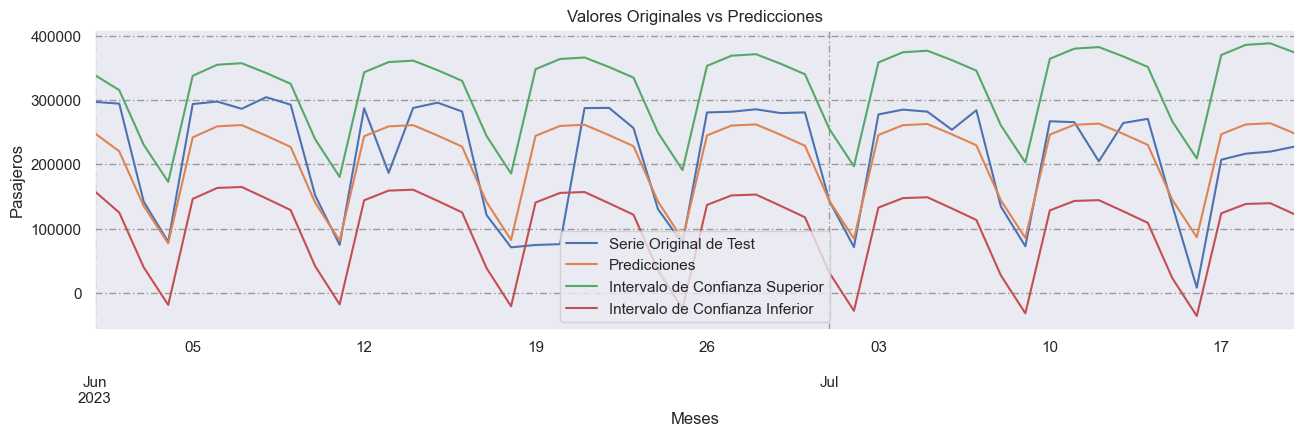

In [65]:
# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:50], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

In [66]:
#Evaluamos las métricas del modelo
evaluar_metricas(test[:50], predicciones_sarima.predicted_mean )

MSE: 2603189791.647284
MAE: 37092.93677256323
RMSE: 51021.46402885049
MAPE: 0.4066


# Pregunta 7

Detallar una comparación con otros modelos estimados

In [67]:
# Pruebo el autoarima sin estacionalidad ( " seasonal = False ")
auto_arima(train, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=False, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15461.980, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15456.073, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15315.235, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15459.986, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15268.432, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15195.153, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15378.895, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15188.195, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15366.692, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15120.227, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15321.194, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=14984.964, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=15131.471, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=14885.249, Time=0.75 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  609
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -7433.675
Date:                Wed, 29 Nov 2023   AIC                          14883.350
Time:                        21:49:53   BIC                          14918.632
Sample:                    09-30-2021   HQIC                         14897.077
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1928      0.036      5.343      0.000       0.122       0.263
ar.L2         -0.7190      0.031    -23.153      0.000      -0.780      -0.658
ar.L3         -0.2693      0.037     -7.347      0.000      -0.341      -0.197
ar.L4         -0.3795      0.026    -14.553      0.000      -0.431      -0.328
ar.L5         -0.4933      0.035    -14.121      0.000      -0.562      -0.425
ma.L1         -0.9521      0.036    -26.178      0.000      -1.023      -0.881
ma.L2          0.6323      0.032     20.008      0.000       0.570       0.694
sigma2      2.123e+09   7.75e-12   2.74e+20      0.000    2.12e+09    2.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               151.27
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.95e+35. Standard errors may be unstable.
"""

In [68]:
modelo_arima = sm.tsa.arima.ARIMA(train, order=(5,1,2), seasonal_order=(0, 0, 0, 0))
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    pas   No. Observations:                  609
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -7433.675
Date:                Wed, 29 Nov 2023   AIC                          14883.350
Time:                        21:50:15   BIC                          14918.632
Sample:                    09-30-2021   HQIC                         14897.077
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1928      0.036      5.343      0.000       0.122       0.263
ar.L2         -0.7190      0.031    -23.153      0.000      -0.780      -0.658
ar.L3         -0.2693      0.037     -7.347      0.000      -0.341      -0.197
ar.L4         -0.3795      0.026    -14.553      0.000      -0.431      -0.328
ar.L5         -0.4933      0.035    -14.121      0.000      -0.562      -0.425
ma.L1         -0.9521      0.036    -26.178      0.000      -1.023      -0.881
ma.L2          0.6323      0.032     20.008      0.000       0.570       0.694
sigma2      2.123e+09   7.75e-12   2.74e+20      0.000    2.12e+09    2.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               151.27
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.95e+35. Standard errors may be unstable.
"""

In [69]:
predicciones_arima = modelo_arima.get_forecast(len(test))

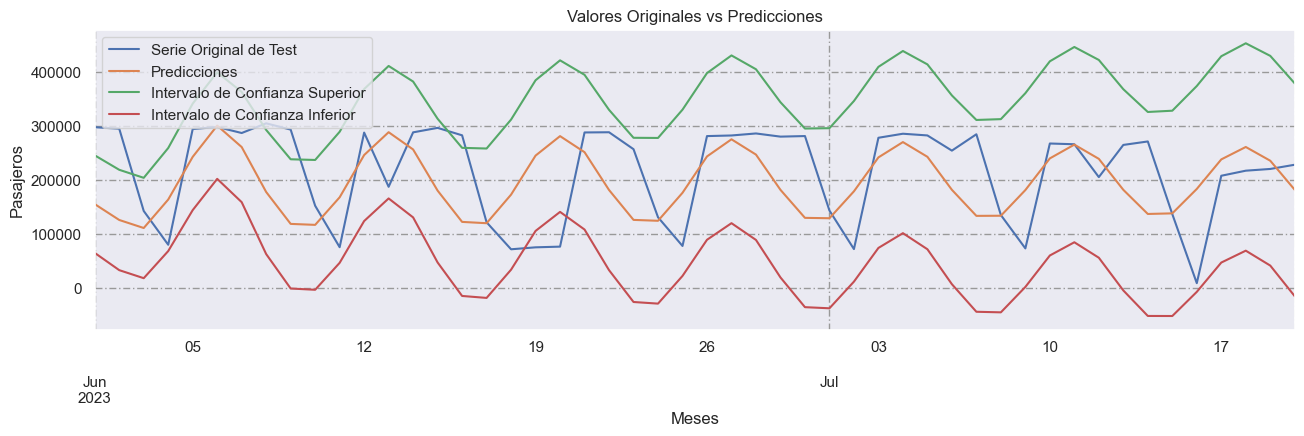

In [70]:
predicciones_arima = modelo_arima.get_forecast(50)

graficar_pred(test[:50], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

In [71]:
evaluar_metricas(test[:50], predicciones_arima.predicted_mean)

MSE: 8836938951.06089
MAE: 74270.8141016415
RMSE: 94004.99428786158
MAPE: 0.8757


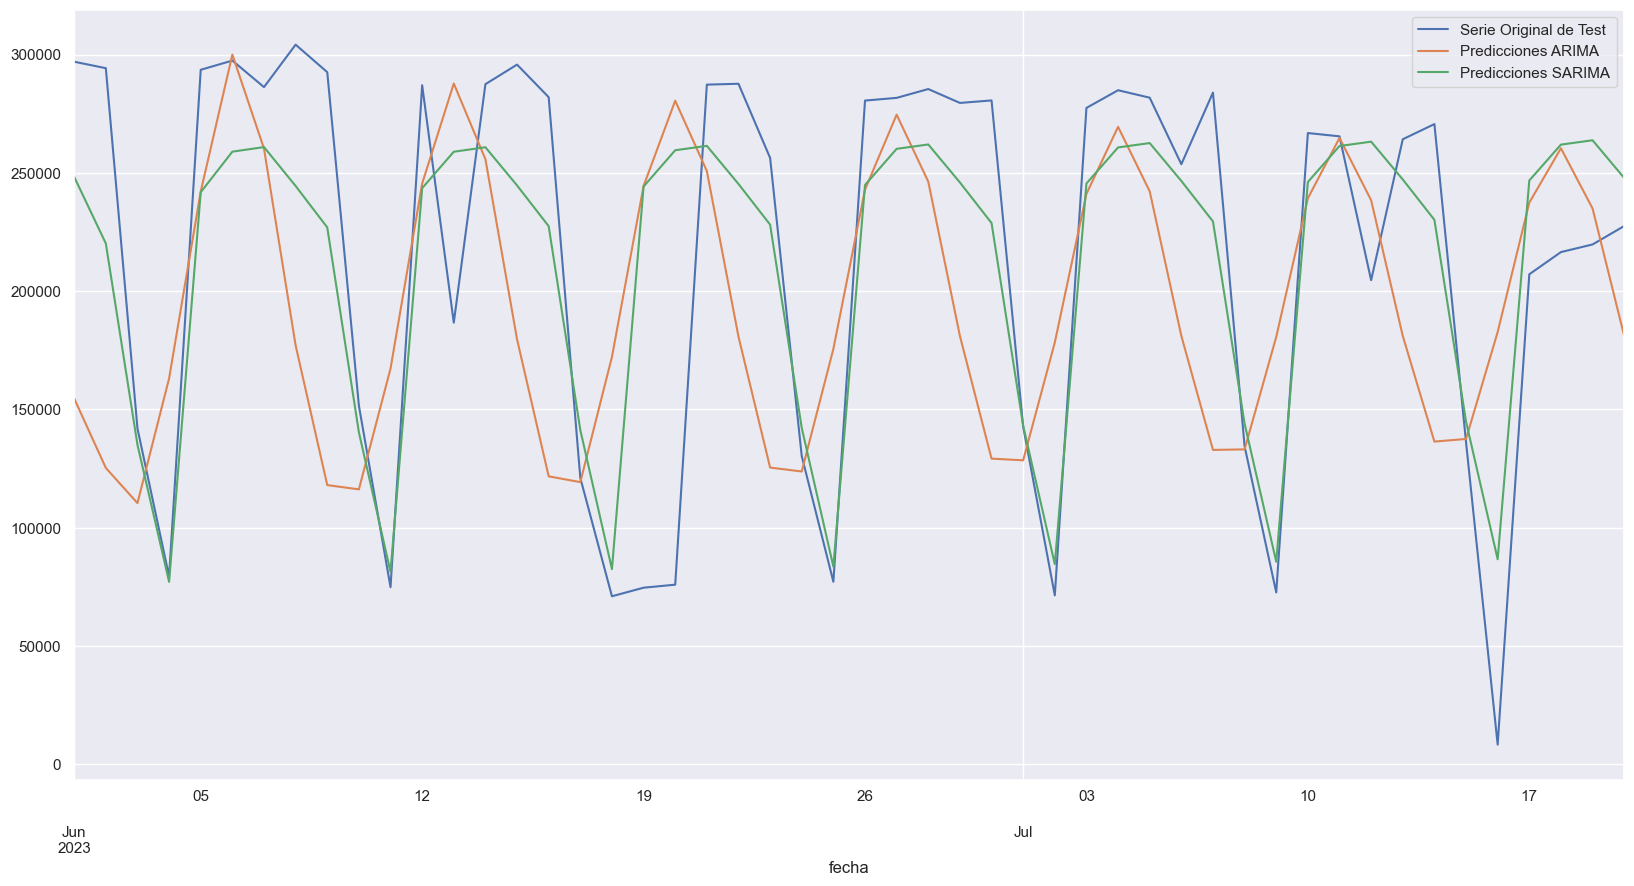

In [72]:
test[:50].plot(label="Serie Original de Test")
predicciones_arima.predicted_mean.plot(label="Predicciones ARIMA")
predicciones_sarima.predicted_mean.plot(label="Predicciones SARIMA")
plt.legend()

In [73]:
datos = {'Modelos': ['SARIMA','ARIMA'],
         'AIC': [modelo_sarima.aic, modelo_arima.aic],
         'BIC': [modelo_sarima.bic, modelo_arima.bic],
         'MAE': [modelo_sarima.mae, modelo_arima.mae],
         'MSE': [modelo_sarima.mse, modelo_arima.mse]}


modelos_residuos = pd.DataFrame(datos)
modelos_residuos

,Modelos,AIC,BIC,MAE,MSE
0,SARIMA,14654.124465,14693.816039,27446.289524,1.638515e+09
1,ARIMA,14883.350329,14918.631728,35453.690225,2.457250e+09


fecha
2021-10-07    -36482.0
2021-10-08    -99892.0
2021-10-09      7968.0
2021-10-10     -2873.0
2021-10-11   -115388.0
                ...   
2023-05-28      7227.0
2023-05-29     -6893.0
2023-05-30     -1451.0
2023-05-31     81869.0
2023-06-01    235932.0
Freq: D, Name: pas, Length: 603, dtype: float64 fecha
2023-06-02    198630.0
2023-06-03     14772.0
2023-06-04      4656.0
2023-06-05      8920.0
2023-06-06     10367.0
                ...   
2023-10-26     -4638.0
2023-10-27    -12722.0
2023-10-28     10067.0
2023-10-29     71664.0
2023-10-30     19742.0
Freq: D, Name: pas, Length: 151, dtype: float64


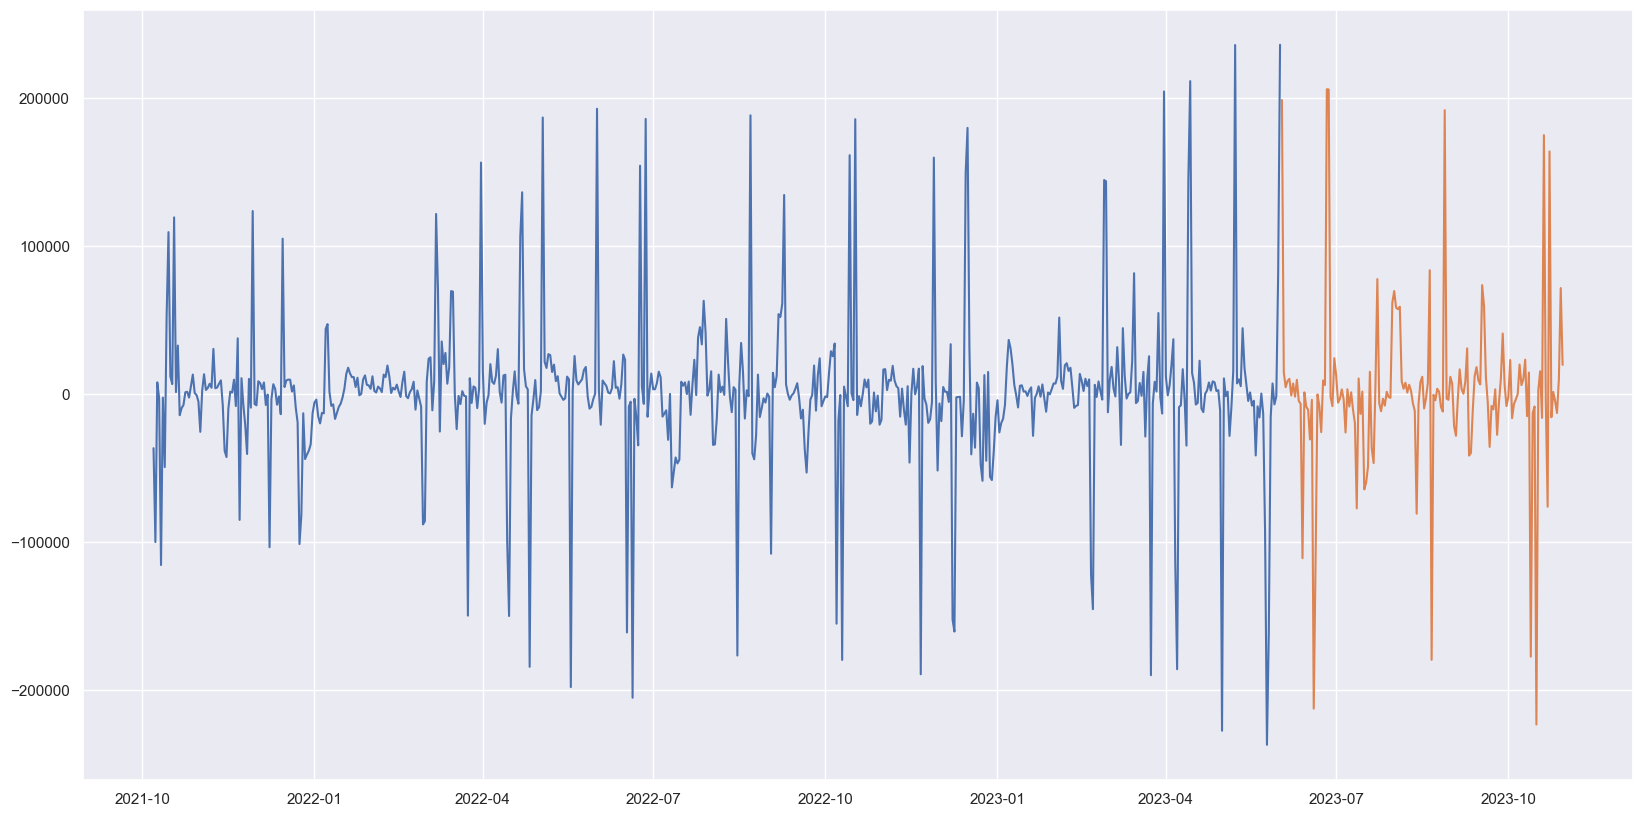

In [74]:
# Separacion Train/Test la serie diferenciada sin estacionalidad
# Seleccionamos el primer 80% para train
train_diff_7 = pas_diff_7.iloc[:round(len(pas_diff_7)*.80)]

# Seleccionamos el 20% restante para test
test_diff_7 = pas_diff_7.iloc[round(len(pas_diff_7)*.80):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train_diff_7, test_diff_7)

# Visualización Train - Test

plt.plot(train_diff_7)
plt.plot(test_diff_7)

In [75]:
# Pruebo el autoarima sin estacionalidad ( " seasonal = False ")
auto_arima(train_diff_7, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=False, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14808.473, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14782.981, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14780.325, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14779.197, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14780.821, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14781.009, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14780.874, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14784.109, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14781.633, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14781.058, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.526 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  603
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -7386.598
Date:                Wed, 29 Nov 2023   AIC                          14779.197
Time:                        21:52:26   BIC                          14792.403
Sample:                    10-07-2021   HQIC                         14784.337
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2780      0.144     -1.924      0.054      -0.561       0.005
ma.L1          0.5096      0.138      3.698      0.000       0.239       0.780
sigma2      2.571e+09   8.63e-11   2.98e+19      0.000    2.57e+09    2.57e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1194.71
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+35. Standard errors may be unstable.
"""

In [45]:
modelo_arima = sm.tsa.arima.ARIMA(train_diff_7, order=(0,0,1), seasonal_order=(0, 0, 0, 0), trend='n')
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    pas   No. Observations:                  679
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8319.819
Date:                Wed, 29 Nov 2023   AIC                          16643.637
Time:                        19:41:19   BIC                          16652.679
Sample:                    10-07-2021   HQIC                         16647.137
                         - 08-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2851      0.028     10.311      0.000       0.231       0.339
sigma2      2.578e+09   3.23e-12   7.98e+20      0.000    2.58e+09    2.58e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1309.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [46]:
predicciones_arima = modelo_arima.get_forecast(len(test_diff_7))

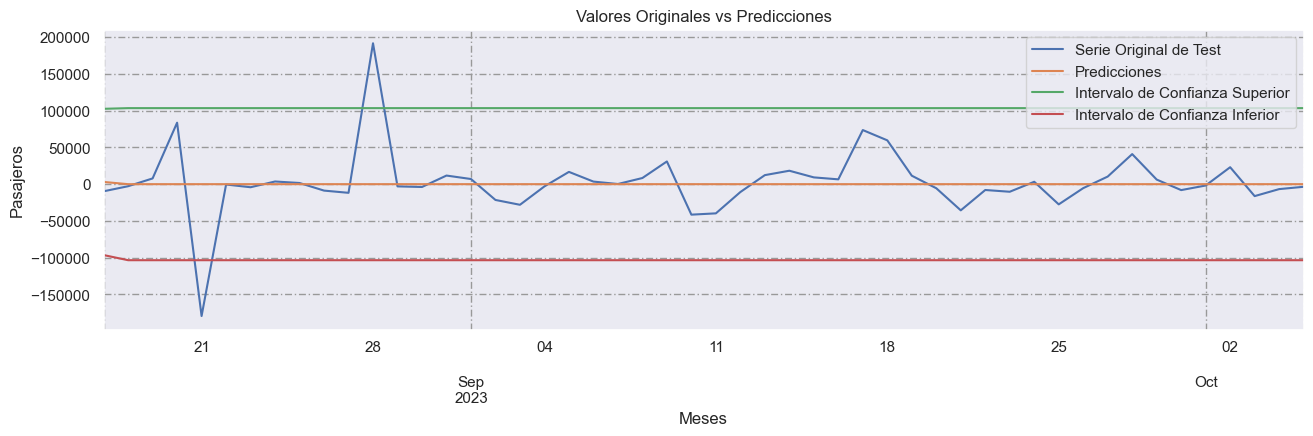

In [47]:
predicciones_arima = modelo_arima.get_forecast(50)

graficar_pred(test_diff_7[:50], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

In [48]:
evaluar_metricas(test_diff_7[:50], predicciones_arima.predicted_mean)

MSE: 1947706053.3166323
MAE: 22844.929613831475
RMSE: 44132.822856878665
MAPE: 1.0063


In [49]:
datos = {'Modelo': ['ARIMA'],
         'AIC': [modelo_arima.aic],
         'BIC': [modelo_arima.bic],
         'MAE': [modelo_arima.mae],
         'MSE': [modelo_arima.mse]}


modelos_residuos = pd.DataFrame(datos)
modelos_residuos

,Modelo,AIC,BIC,MAE,MSE
0,ARIMA,16643.637348,16652.67859,27537.176499,2.572579e+09


# Pregunta 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

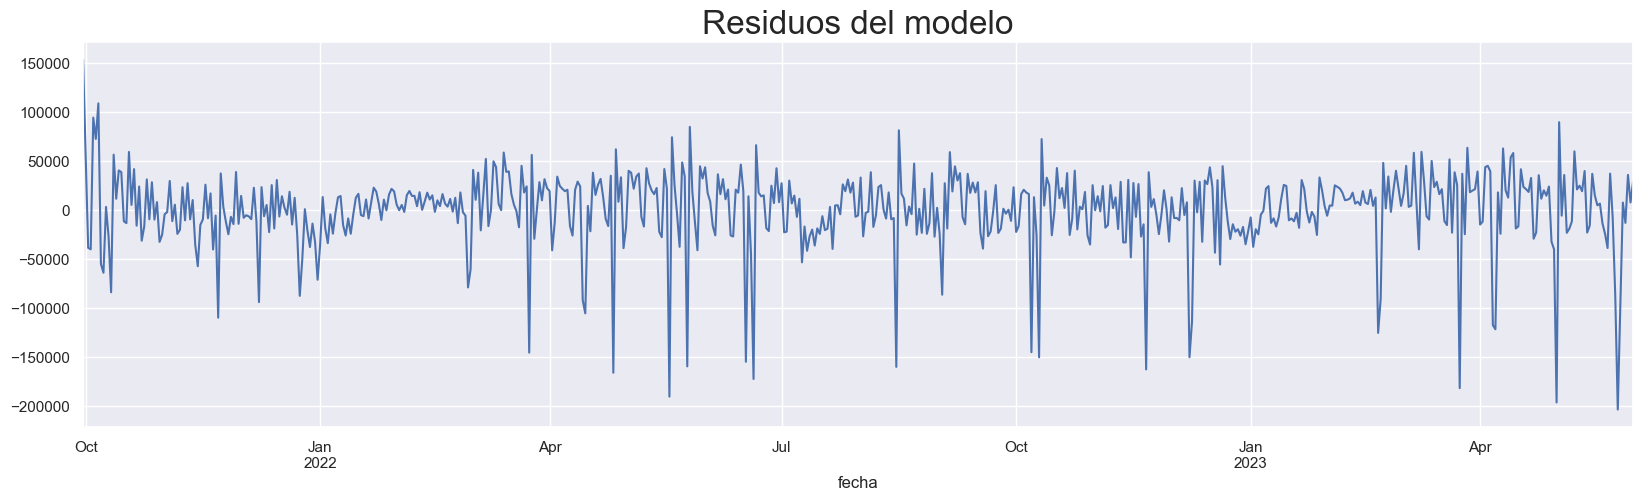

In [30]:
modelo_sarima.resid.plot(figsize = (20, 5))
plt.title("Residuos del modelo", size = 24)
plt.show()

Text(0.5, 1.0, 'Histograma de los residuos del modelo')

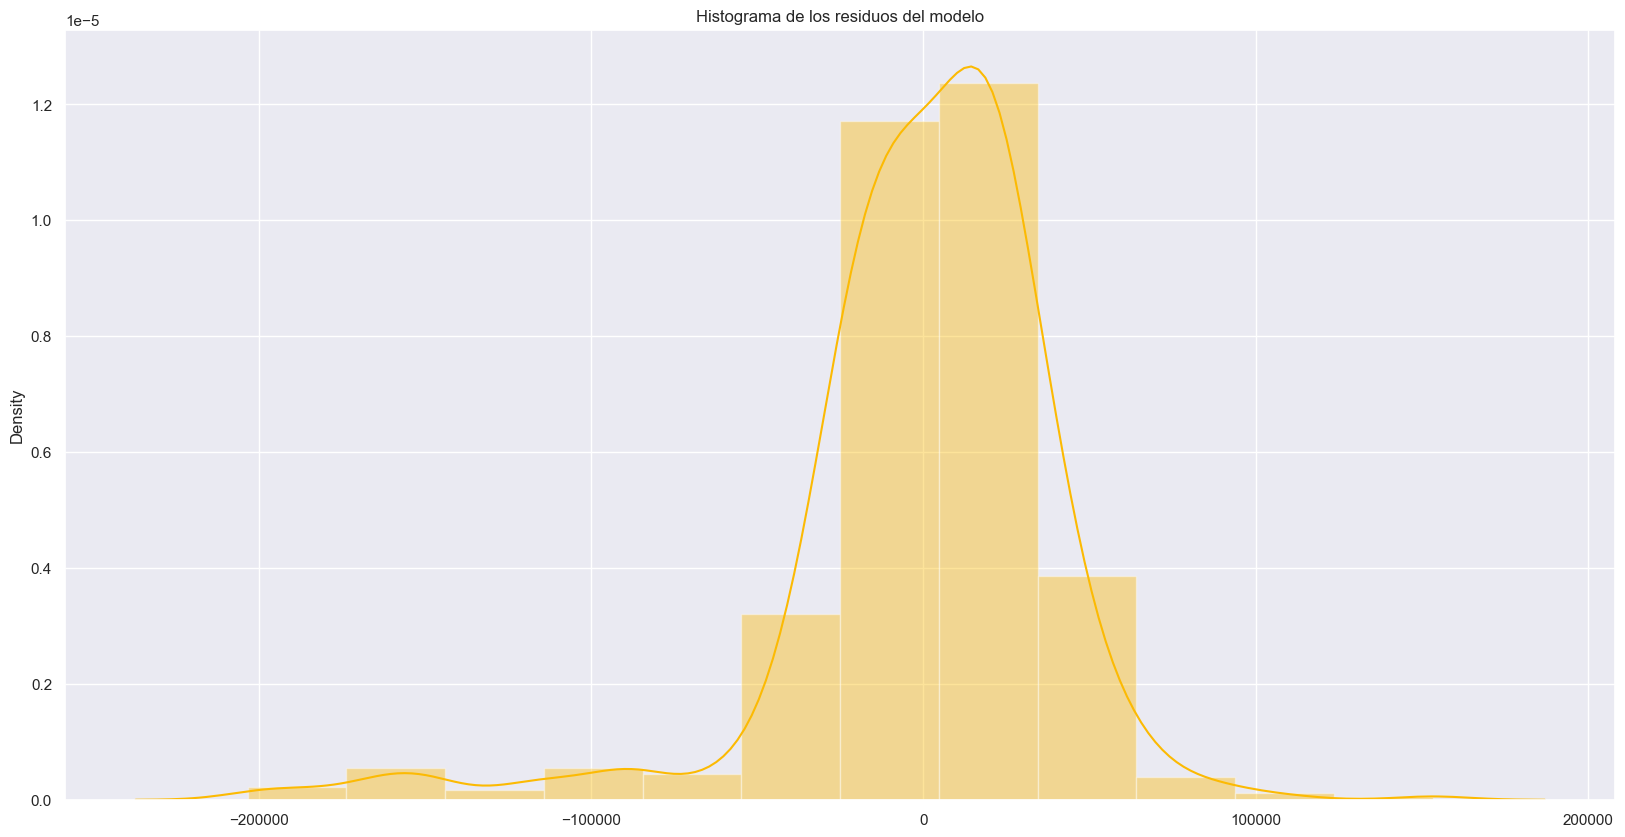

In [31]:
sns.distplot(modelo_sarima.resid,bins=12,color='#fcba03')
plt.title('Histograma de los residuos del modelo')

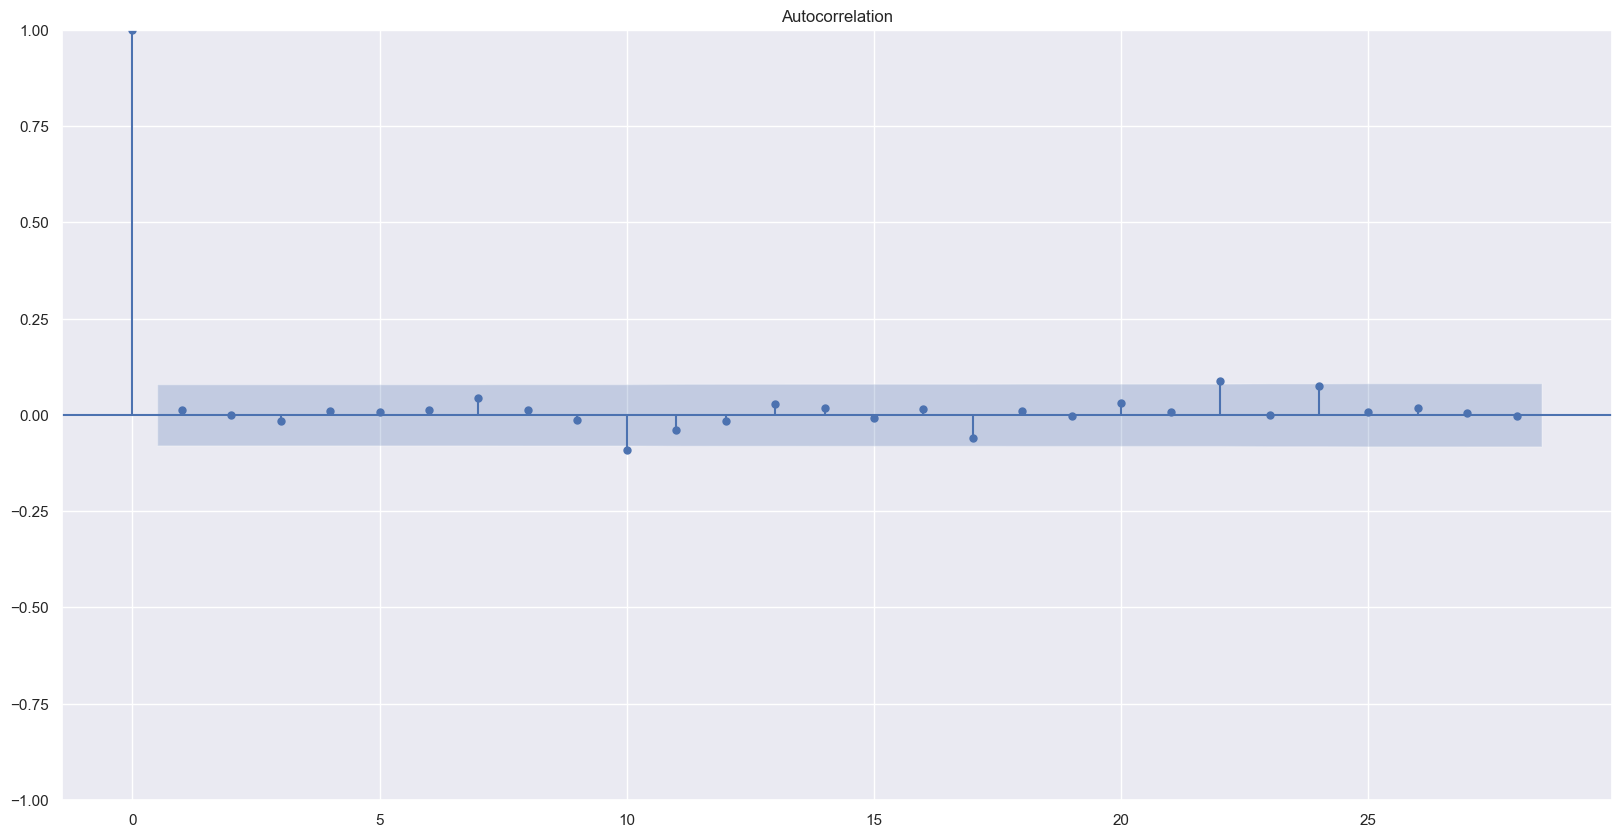

In [32]:
plot_acf(modelo_sarima.resid);

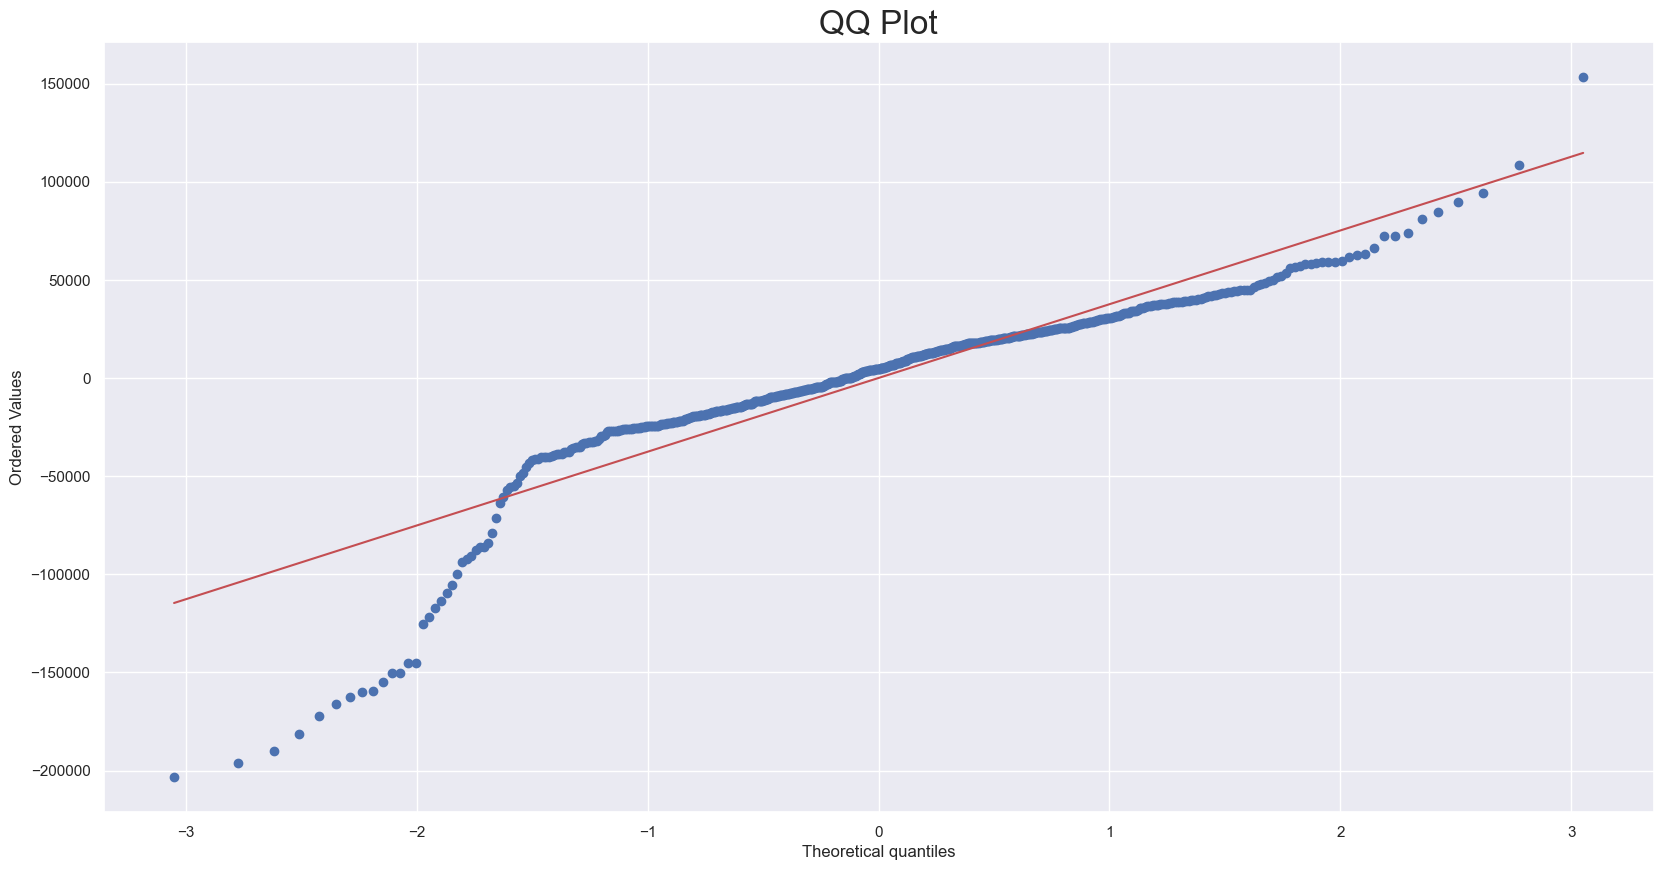

In [33]:
scipy.stats.probplot(modelo_sarima.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

Aqui trabajamos con el test de L-Jung Box. Trabajamos la incorrelacion o no de los residuos del modelo. Si hay algun valor que rechazo, entonces algun componente no estoy especificando bien en mi modelo y tiene correlacion. Entonces, tendria que incorporarlo a la especificacion. Este test es fundamental cuando analizo los residuos del modelo que tienen que comportarse como un ruido blanco.

In [34]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(modelo_sarima.resid, lags=30)

In [35]:
Incorr_residuos_modelo

,lb_stat,lb_pvalue
1,0.105837,0.744934
2,0.106626,0.948083
3,0.259161,0.967517
4,0.311538,0.989057
5,0.356115,0.996453
6,0.451265,0.998382
7,1.698502,0.974632
8,1.804084,0.986440
9,1.929069,0.992540
10,7.152905,0.710935


Text(0, 0.5, 'P-valores ')

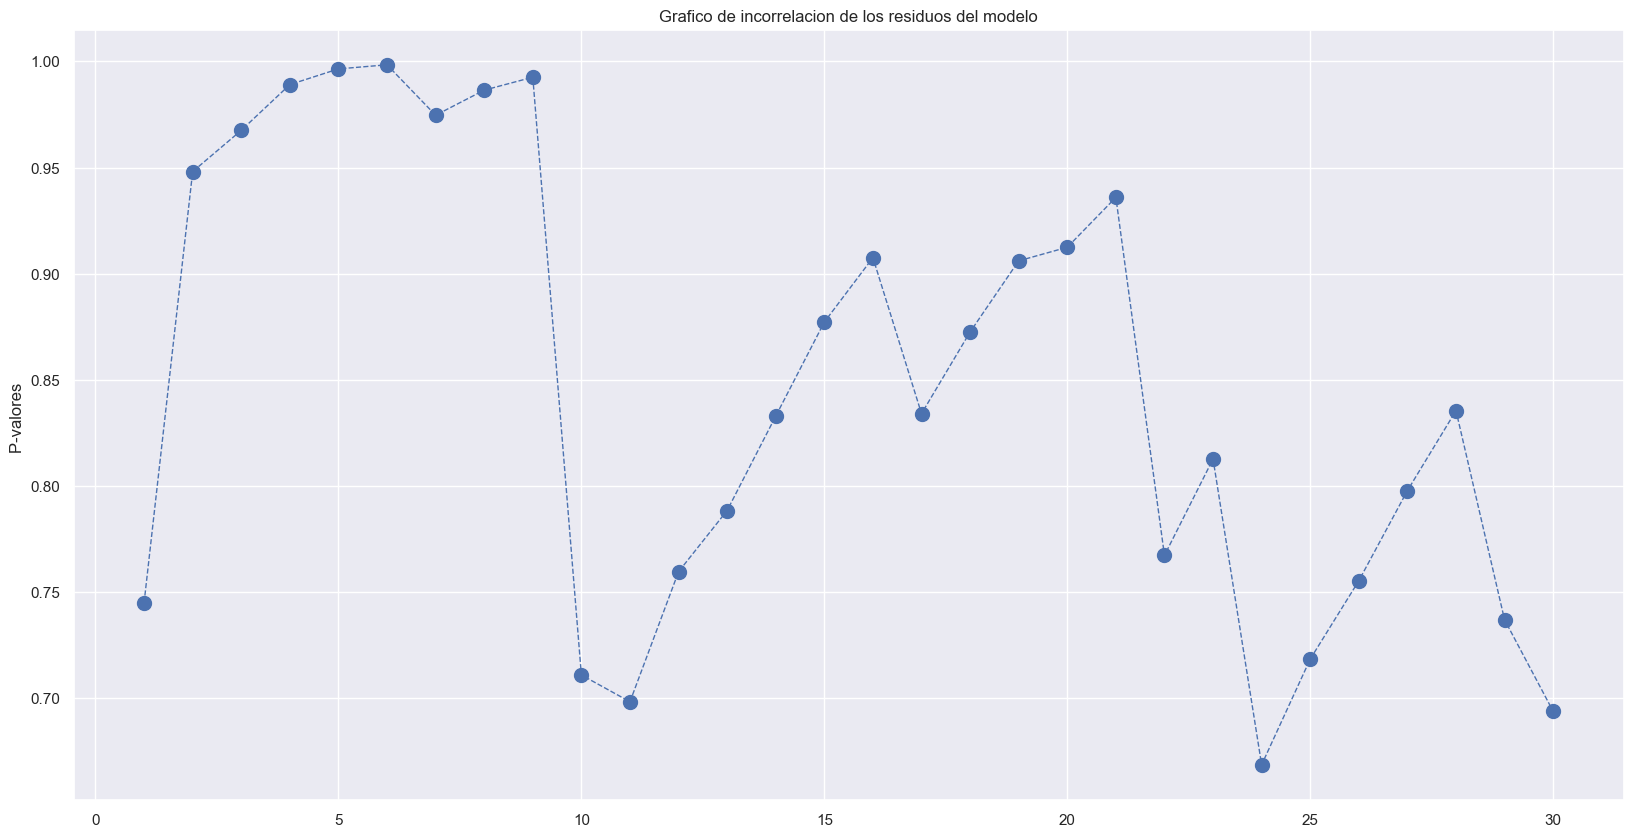

In [36]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

Si los residuos del modelo se comportan como ruido blanco, hacemos la proyeccion. En este caso se comportan como ruido blanco y continuamos con el proceso.

# Pregunta 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

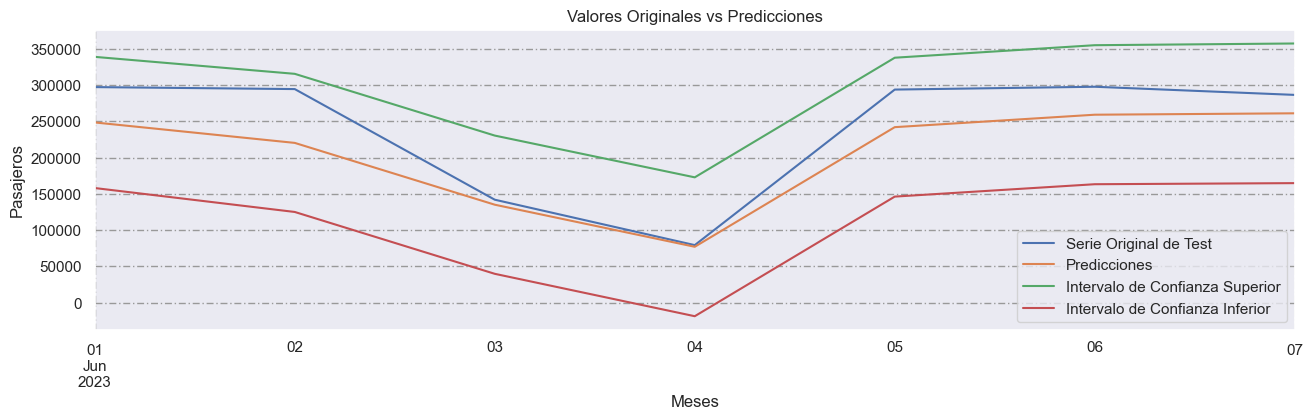

In [40]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 50 días del test
predicciones_sarima = modelo_sarima.get_forecast(7)

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:7], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

# Pregunta 10

Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.

Se preparan las 3 variables en el mismo rango temporal.

In [22]:
# Consumo
url = 'https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Consumo_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
consumo_d = raw_csv_data.copy()
consumo_d = consumo_d[(consumo_d['Fecha'] >= '2021-10-01') & (consumo_d['Fecha'] <= '2023-10-30')]
consumo_d = consumo_d.loc[consumo_d.Consumo>0]
consumo_d.rename({'Fecha': 'fecha', 'Consumo': 'con'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'con': 1},
                                     {'fecha': '2022-10-12', 'con': 1},
                                     {'fecha': '2022-10-13', 'con': 1},
                                     {'fecha': '2023-06-13', 'con': 1},
                                     {'fecha': '2023-06-22', 'con': 1}])
consumo_d = pd.concat([consumo_d, nuevas_observaciones], ignore_index=True)

# Ordenar el DataFrame por la columna de fechas
consumo_d = consumo_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
consumo_d = consumo_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
consumo_d['fecha'] = pd.to_datetime(consumo_d['fecha'], dayfirst=True, format="%Y-%m-%d")

In [23]:
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_22

# Formato diario
consumo_d.set_index('fecha', inplace=True)

consumo_d = consumo_d.asfreq('d')
consumo_d = consumo_d['con']
consumo_d.describe()

count    760.000000
mean      46.018249
std        3.446071
min       21.671538
25%       44.059896
50%       46.227106
75%       48.002559
max       55.802864
Name: con, dtype: float64

In [24]:
# KM
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Kilometros_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
km_d = raw_csv_data.copy()
km_d = km_d[(km_d['Fecha'] >= '2021-10-01') & (km_d['Fecha'] <= '2023-10-30')]

km_d.rename({'Fecha': 'fecha', 'KM': 'km'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2023-06-22', 'km': 1}])
km_d = pd.concat([km_d, nuevas_observaciones], ignore_index=True)
km_d = km_d.sort_values(by=['fecha'], ascending=True)
km_d = km_d.reset_index(drop=True)
# Convertir la columna 'Fecha' a tipo datetime
km_d['fecha'] = pd.to_datetime(km_d['fecha'], dayfirst=True, format="%Y-%m-%d")

In [25]:
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = km_d.index[km_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_22

# Formato diario
km_d.set_index('fecha', inplace=True)

km_d = km_d.asfreq('d')
km_d = km_d['km']
km_d.describe()

count       760.000000
mean      73977.713023
std       23424.039351
min       17554.422000
25%       52696.933750
50%       75397.900000
75%       97051.868000
max      105834.661000
Name: km, dtype: float64

In [26]:
# Realizamos el merge de los tres conjuntos de datos
serieVAR=pd.concat([pasajeros_d, km_d, consumo_d], axis=1)

In [27]:
# Separacion Train/Test

# Seleccion de train
train = serieVAR[:-14]  # Tomar todas las observaciones excepto las últimas 14

# Seleccionamos de test
test = serieVAR[-14:]  # Tomar los últimos 14 elementos

# Corroboramos que los límites se hayan establecido según lo planificado
print(train, "\n\n", test)


               pas          km        con
fecha                                    
2021-10-01  163933   73177.190  45.201497
2021-10-02   71862   49300.256  39.899719
2021-10-03   41802   34024.972  39.705724
2021-10-04  159940   73453.515  45.777167
2021-10-05  170473   73722.635  46.147136
...            ...         ...        ...
2023-10-12  319953  100921.656  47.132878
2023-10-13  123015   44550.463  45.812691
2023-10-14  142922   60757.829  45.078861
2023-10-15   81588   45225.920  43.659297
2023-10-16   75418   44817.861  40.860755

[746 rows x 3 columns] 

                pas          km        con
fecha                                    
2023-10-17  302086  102048.735  47.007409
2023-10-18  299698  103438.338  45.018029
2023-10-19  303919  101205.310  46.920585
2023-10-20  297951  101546.738  47.454229
2023-10-21  138731   61042.359  44.124254
2023-10-22    5582   47321.881  44.044581
2023-10-23  239320  101572.556  43.281193
2023-10-24  286480  101884.237  45.218363
2023-10

In [30]:
from statsmodels.tsa.api import VAR

In [31]:
model = VAR(train.diff()[1:])

- AIC (Akaike Information Criterion)
- BIC (Bayesian Information Criterion)
- FPE (Final Prediction Error)
- HQIC (Hannan-Quinn Information Criterion)

A continuación se utiliza el método select_order del modelo VAR (model) para seleccionar el orden adecuado del modelo VAR basado en criterios estadísticos. El parámetro maxlags se establece en 14, lo que significa que el código considerará modelos VAR con hasta 14 rezagos.

In [32]:
x = model.select_order(maxlags=14)
x.summary()

,AIC,BIC,FPE,HQIC
0,42.01,42.02,1.748e+18,42.01
1,41.77,41.85,1.387e+18,41.80
2,41.54,41.67,1.099e+18,41.59
3,41.42,41.61,9.729e+17,41.49
4,41.30,41.55,8.672e+17,41.40
5,40.89,41.19,5.750e+17,41.01
6,40.23,40.58*,2.951e+17,40.36*
7,40.23,40.64,2.960e+17,40.39
8,40.23,40.70,2.960e+17,40.41
9,40.23,40.76,2.969e+17,40.44


In [33]:
model_fitted = model.fit(13)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Nov, 2023
Time:                     19:07:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    40.8905
Nobs:                     732.000    HQIC:                   40.4277
Log likelihood:          -17686.2    FPE:                2.70065e+17
AIC:                      40.1371    Det(Omega_mle):     2.30224e+17
--------------------------------------------------------------------
Results for equation pas
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const         804.582394      1653.696708            0.487           0.627
L1.pas         -0.581416         0.117190           -4.961           0.000
L1.km          -0.474849         0.408347           -1.163           0.245
L1.con     

## Forecast

In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

13


array([[2.99088000e+05, 1.02203378e+05, 4.62263687e+01],
       [3.05377000e+05, 1.01982822e+05, 4.65574838e+01],
       [3.00296000e+05, 1.01565756e+05, 4.67482428e+01],
       [1.55618000e+05, 6.16452320e+04, 4.39720967e+01],
       [8.99390000e+04, 4.52894580e+04, 4.02548836e+01],
       [2.98523000e+05, 1.02141443e+05, 4.89554634e+01],
       [2.99487000e+05, 1.01892962e+05, 4.66526424e+01],
       [2.84205000e+05, 1.01517207e+05, 4.51096263e+01],
       [3.19953000e+05, 1.00921656e+05, 4.71328780e+01],
       [1.23015000e+05, 4.45504630e+04, 4.58126907e+01],
       [1.42922000e+05, 6.07578290e+04, 4.50788608e+01],
       [8.15880000e+04, 4.52259200e+04, 4.36592972e+01],
       [7.54180000e+04, 4.48178610e+04, 4.08607546e+01]])

In [35]:
# Forecast
n_forecast = 14
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=serieVAR.index[-n_forecast:], columns=serieVAR.columns + '_1d')
df_forecast

,pas_1d,km_1d,con_1d
fecha,,,
2023-10-17,-1.338378e+06,-441230.942295,-202.721512
2023-10-18,-1.575792e+05,-52258.402064,-35.350403
2023-10-19,1.778379e+05,38189.159197,6.810077
2023-10-20,-1.066758e+05,-23636.976494,14.445307
2023-10-21,9.772994e+04,20033.137472,18.384652
2023-10-22,1.559196e+05,53375.676902,15.280830
2023-10-23,1.833255e+05,27124.364567,18.819322
2023-10-24,-5.842203e+05,-173021.570945,-28.538653
2023-10-25,2.473063e+05,87752.571139,6.445876


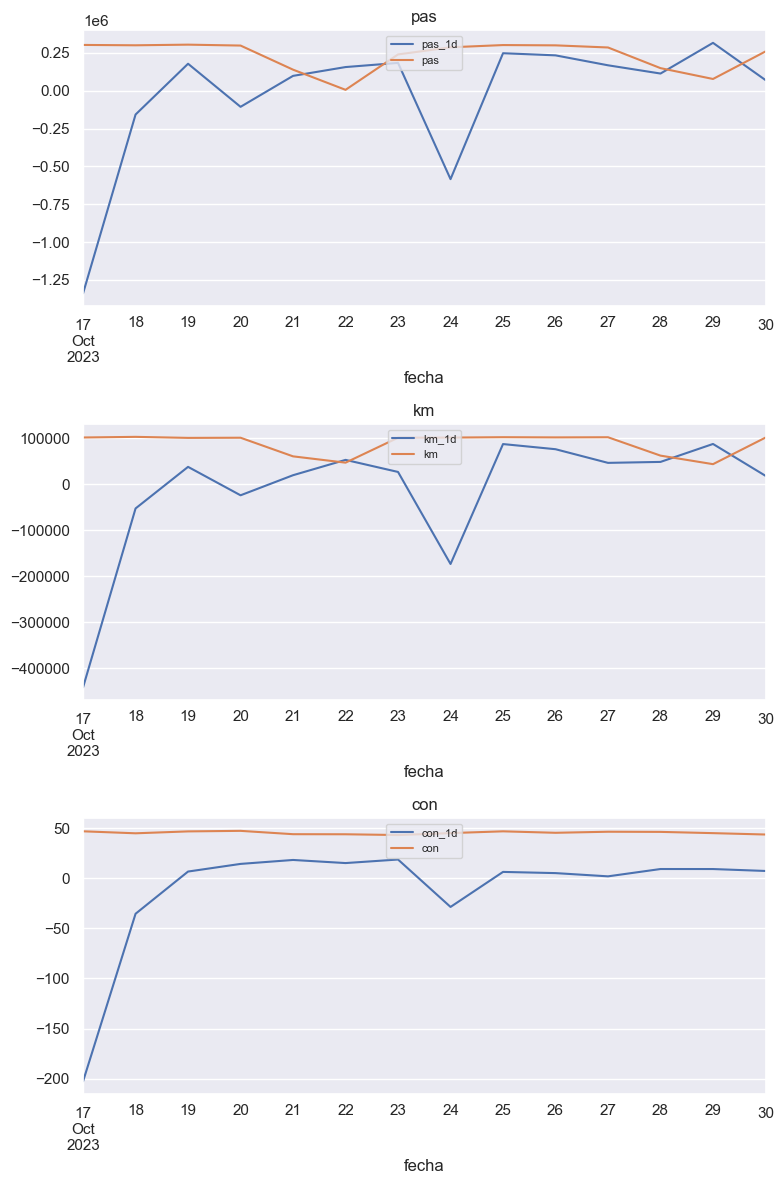

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col, ax) in enumerate(zip(serieVAR.columns, axes.flatten())):
    df_forecast[col+'_1d'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test[col][-n_forecast:].plot(legend=True, ax=ax)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.legend(fontsize="8", loc='upper center')

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficas
plt.show()

In [37]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [38]:
df_results = invert_transformation(train, df_forecast, second_diff=False)
df_results.loc[:, ['pas_forecast', 'km_forecast', 'con_forecast']]

,pas_forecast,km_forecast,con_forecast
fecha,,,
2023-10-17,-1.262960e+06,-396413.081295,-161.860757
2023-10-18,-1.420539e+06,-448671.483359,-197.211160
2023-10-19,-1.242701e+06,-410482.324162,-190.401083
2023-10-20,-1.349377e+06,-434119.300656,-175.955776
2023-10-21,-1.251647e+06,-414086.163184,-157.571123
2023-10-22,-1.095727e+06,-360710.486281,-142.290294
2023-10-23,-9.124017e+05,-333586.121715,-123.470971
2023-10-24,-1.496622e+06,-506607.692660,-152.009624
2023-10-25,-1.249316e+06,-418855.121521,-145.563748


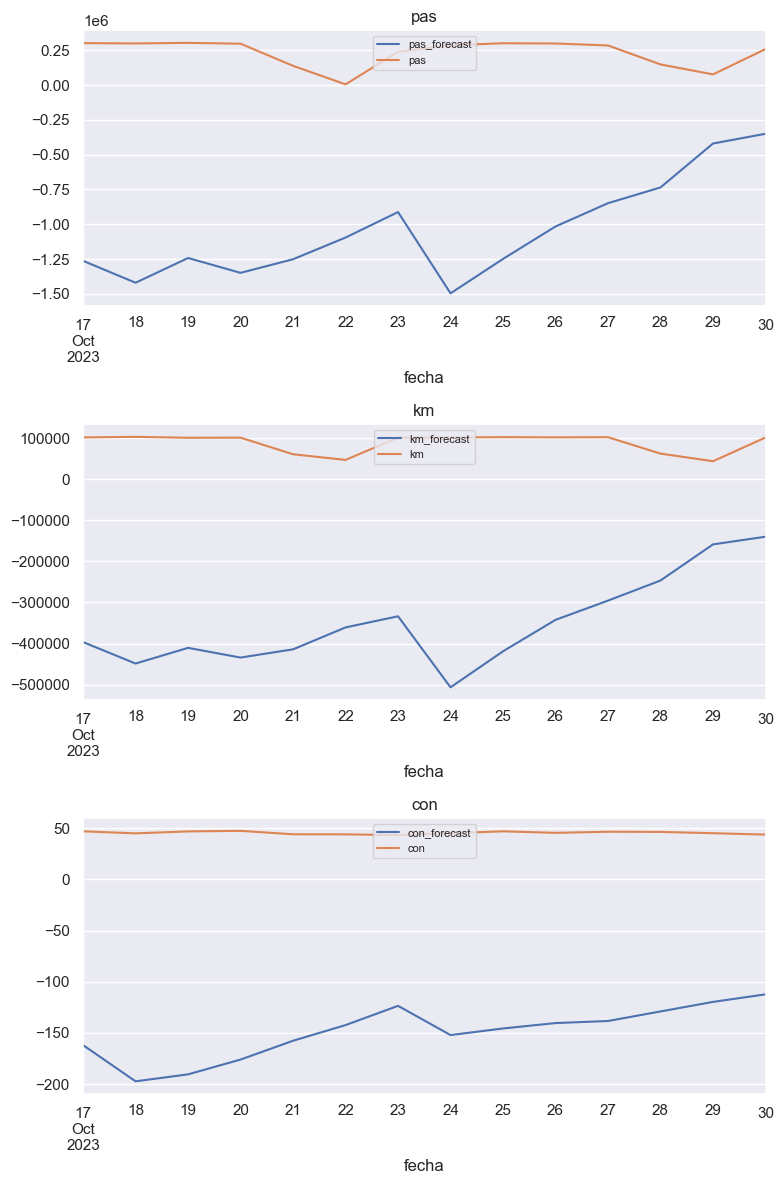

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(8, 12))

for i, (col, ax) in enumerate(zip(serieVAR.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test[col][-n_forecast:].plot(legend=True, ax=ax)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.legend(fontsize="8", loc='upper center')

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficas
plt.show()

### Análisis de residuos:

In [40]:
print(model_fitted.summary()._resid_info())

Correlation matrix of residuals
            pas        km       con
pas    1.000000  0.944468  0.337425
km     0.944468  1.000000  0.299910
con    0.337425  0.299910  1.000000




Residuos correlacionados. En este caso, parece haber correlaciones positivas significativas entre los residuos de las tres variables, lo que sugiere que podría haber relaciones de corto plazo entre estas variables en el modelo VAR.

In [42]:
residuos_analisis= model_fitted.resid
residuos_analisis

,pas,km,con
fecha,,,
2021-10-15,36052.468701,8570.060096,3.864697
2021-10-16,-14407.170637,-3585.184487,1.101092
2021-10-17,-6136.776785,-6164.172448,-1.923699
2021-10-18,45010.764304,18191.719904,2.599713
2021-10-19,-10210.713982,-2167.995637,-0.832544
...,...,...,...
2023-10-12,16976.126571,-3019.551951,0.964071
2023-10-13,-170489.175679,-52543.367213,-1.328658
2023-10-14,25717.322164,13020.976043,0.845106


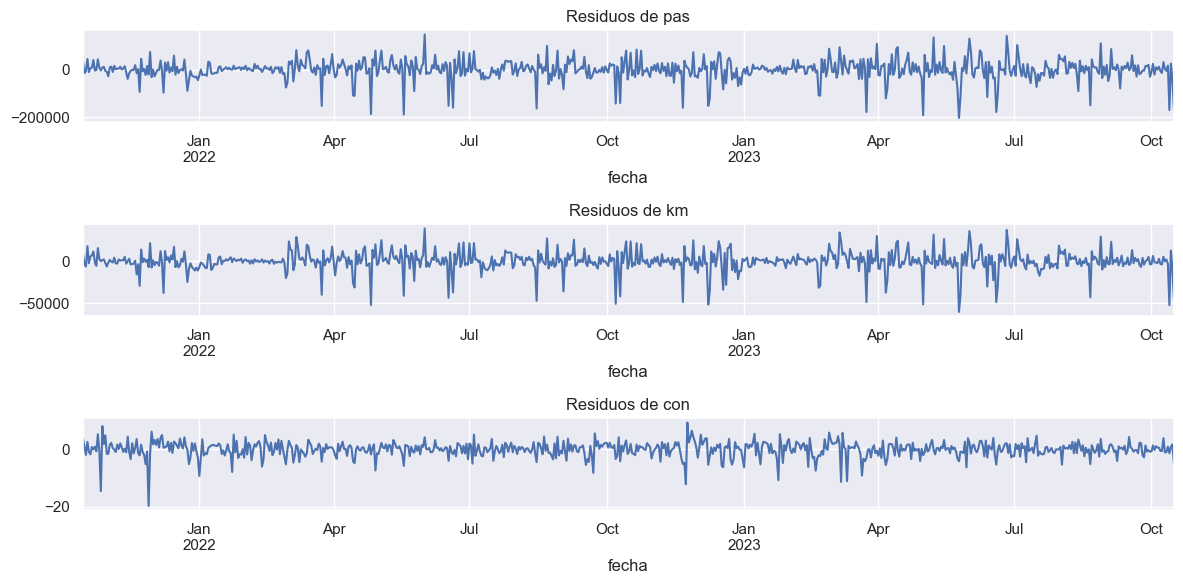

In [43]:
fig, axs = plt.subplots(nrows=residuos_analisis.shape[1], figsize=(12, 6))

for i, col in enumerate(residuos_analisis.columns):
    residuos_analisis[col].plot(ax=axs[i])
    axs[i].set_title(f'Residuos de {col}')

plt.tight_layout()
plt.show()

In [44]:
residuos_analisis.describe()

,pas,km,con
count,7.320000e+02,7.320000e+02,7.320000e+02
mean,-1.987967e-12,-2.286162e-12,-2.256847e-16
std,4.346422e+04,1.226752e+04,2.684387e+00
min,-2.036297e+05,-6.063874e+04,-1.973278e+01
25%,-1.565820e+04,-3.967753e+03,-1.267935e+00
50%,1.246383e+03,1.237997e+02,2.876628e-01
75%,1.854425e+04,4.815218e+03,1.584133e+00
max,1.486147e+05,3.948622e+04,9.399981e+00


# Pregunta 11

Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis.

## Criterio de Granger
La hipótesis nula supone que el pasado de una variable no proporciona información adicional para predecir la otra variable más allá de lo que ya se puede predecir utilizando solo su propio pasado.

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

# P-valores menores al nivel de significancia (0.05) implica que la hipotesis nula (X no causa Y) puede rechazarse.
# testgr: Es el tipo de prueba que se utilizará para evaluar la causalidad de Granger. Por defecto, se utiliza 'ssr_chi2test', que es una prueba basada en chi-cuadrado,

def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):


    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# se agrega '_x' al final de los nombres de las columnas para indicar que son las variables "causantes" y '_y' al final de los nombres de las filas para indicar que son las variables "afectadas".

* H0: La serie temporal X no causa grangerianamente la serie temporal Y.
* H1: La serie temporal X causa grangerianamente la serie temporal Y.

In [29]:
testgr = 'ssr_chi2test'
grangers_causation_matrix(train, variables = train.columns, maxlag=10)

,pas_x,km_x,con_x
pas_y,9.999998e-01,8.707420e-03,9.031799e-14
km_y,3.935351e-03,1.000000e+00,2.274421e-12
con_y,1.348021e-15,7.585876e-18,1.000000e+00


Interpretación: Basándonos en el resultado de la prueba de causalidad de Granger, podemos afirmar que los valores pasados de Serie A (con un rezagos máximos de 10 períodos) proporcionan información estadísticamente significativa para predecir los valores futuros de Serie B. Esto sugiere una relación de causalidad grangeriana de Serie A hacia Serie B en este contexto específico.

# Pregunta 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior. 

Opcional: Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.